In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

In [2]:
all_letters = string.ascii_letters + ",.:'-"
n_letters = len(all_letters) + 1

In [3]:
def findFiles(path): return glob.glob(path)

Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

Read a file and split into lines

In [5]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

Build the category_lines dictionary, a list of lines per category

In [6]:
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [7]:
len(all_categories)

18

In [8]:
n_categories = len(all_categories)

In [9]:
print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Vietnamese', 'German', 'English', 'Korean', 'Portuguese', 'Chinese', 'Dutch', 'Scottish', 'French', 'Irish', 'Spanish', 'Czech', 'Russian', 'Polish', 'Japanese', 'Italian', 'Greek']
O'Neal


### Creating the Network

In [10]:
import torch
import torch.nn as nn

In [38]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

### Training

In [13]:
import random

In [26]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [17]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters(not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end(EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)
    return torch.LongTensor(letter_indexes)

In [75]:
# Make category, input and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
#     print(category, line)
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

### Training the Network

In [42]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
        
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add(-learning_rate, p.grad.data)
    
    return output, loss.item() / input_line_tensor.size(0)

In [45]:
import time 
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    return '%dm %ds' % (m, s)

In [46]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))
    
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 33s (5000 5%) 4.0618
1m 67s (10000 10%) 4.0387
1m 101s (15000 15%) 4.0509
2m 135s (20000 20%) 4.0635
2m 169s (25000 25%) 4.0524
3m 203s (30000 30%) 4.0965
3m 237s (35000 35%) 4.0528
4m 271s (40000 40%) 4.1064
5m 305s (45000 45%) 4.0418
5m 339s (50000 50%) 4.0914
6m 373s (55000 55%) 4.0574
6m 408s (60000 60%) 4.0734
7m 442s (65000 65%) 4.0104
7m 476s (70000 70%) 4.0952
8m 510s (75000 75%) 4.0856
9m 544s (80000 80%) 4.0723
9m 578s (85000 85%) 4.0393
10m 612s (90000 90%) 4.0660
10m 647s (95000 95%) 4.0969
11m 681s (100000 100%) 4.0228


In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

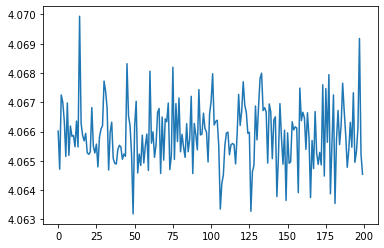

In [48]:
plt.figure()
plt.plot(all_losses)

In [55]:
max_length = 20

def sample(category, start_letter='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter
        
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
#             print(topv, topi)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
        
        return output_name

In [63]:
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [76]:
samples('Chinese', 'G')

GuGzAAAGununununununL
